# 条件
1. 学年の全生徒をそれぞれ１つのクラスに割り当てる
1. 各クラスの生徒の人数は39人以上、40人以下
1. 各クラスの男子生徒、女子生徒の人数は20人以下
1. 各クラスの学力試験の平均点は学年平均±10点とする
1. 各クラスにリーダー気質の生徒を2人以上割り当てる
1. 特別な支援が必要な生徒は各クラスに1人以下とする
1. 特定ペアの生徒は同一クラスに割り当てない

In [1]:
!ls

school.ipynb  student_pairs.csv  students.csv


In [2]:
import pandas as pd
import pulp

In [3]:
df_st = pd.read_csv('students.csv')
df_st

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317
...,...,...,...,...,...
313,314,0,0,0,244
314,315,1,0,0,309
315,316,0,0,0,239
316,317,1,0,0,356


In [4]:
df_st.describe()

,student_id,gender,leader_flag,support_flag,score
count,318.000000,318.000000,318.000000,318.000000,318.000000
mean,159.500000,0.496855,0.053459,0.012579,303.644654
std,91.942917,0.500778,0.225302,0.111622,65.179995
min,1.000000,0.000000,0.000000,0.000000,88.000000
25%,80.250000,0.000000,0.000000,0.000000,261.000000
50%,159.500000,0.000000,0.000000,0.000000,310.000000
75%,238.750000,1.000000,0.000000,0.000000,350.000000
max,318.000000,1.000000,1.000000,1.000000,485.000000


In [5]:
df_pr = pd.read_csv('student_pairs.csv')
df_pr

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


In [6]:
set(range(1, 319)) == set(df_st.student_id)

True

In [7]:
df_st.gender.value_counts()

0    160
1    158
Name: gender, dtype: int64

In [8]:
df_st.leader_flag.value_counts()

0    301
1     17
Name: leader_flag, dtype: int64

In [9]:
df_st.support_flag.value_counts()

0    314
1      4
Name: support_flag, dtype: int64

<AxesSubplot:>

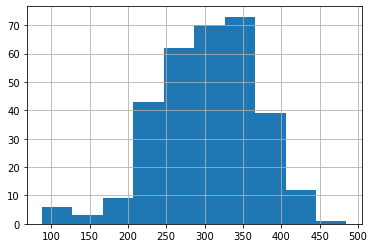

In [10]:
df_st.score.hist()

In [11]:
df_st.index = df_st.student_id.tolist()
df_st

,student_id,gender,leader_flag,support_flag,score
1,1,0,0,0,335
2,2,1,0,0,379
3,3,0,0,0,350
4,4,0,0,0,301
5,5,1,0,0,317
...,...,...,...,...,...
314,314,0,0,0,244
315,315,1,0,0,309
316,316,0,0,0,239
317,317,1,0,0,356


In [12]:
len(df_st.student_id) // 40 + 1

8

In [13]:
max_class = 40
min_class = 39
num_of_class = len(df_st.student_id) // 40 + 1
mean_score = df_st.score.mean()


In [14]:
st_list = df_st.student_id.tolist()

In [15]:
df_x = pd.DataFrame([[f'x_{i}_{c}' for c in range(num_of_class)] for i in st_list], index = st_list)
df_x

,0,1,2,3,4,5,6,7
1,x_1_0,x_1_1,x_1_2,x_1_3,x_1_4,x_1_5,x_1_6,x_1_7
2,x_2_0,x_2_1,x_2_2,x_2_3,x_2_4,x_2_5,x_2_6,x_2_7
3,x_3_0,x_3_1,x_3_2,x_3_3,x_3_4,x_3_5,x_3_6,x_3_7
4,x_4_0,x_4_1,x_4_2,x_4_3,x_4_4,x_4_5,x_4_6,x_4_7
5,x_5_0,x_5_1,x_5_2,x_5_3,x_5_4,x_5_5,x_5_6,x_5_7
...,...,...,...,...,...,...,...,...
314,x_314_0,x_314_1,x_314_2,x_314_3,x_314_4,x_314_5,x_314_6,x_314_7
315,x_315_0,x_315_1,x_315_2,x_315_3,x_315_4,x_315_5,x_315_6,x_315_7
316,x_316_0,x_316_1,x_316_2,x_316_3,x_316_4,x_316_5,x_316_6,x_316_7
317,x_317_0,x_317_1,x_317_2,x_317_3,x_317_4,x_317_5,x_317_6,x_317_7


In [16]:
problem = pulp.LpProblem('school-class', pulp.LpMaximize)
x = pd.DataFrame([[pulp.LpVariable(f'x_{i}_{c}',cat='Binary') for c in range(num_of_class)] for i in st_list], index=st_list)

for i in x.index:
    problem += pulp.lpSum(x.loc[i,:]) == 1 # condition 1

for j in x.columns:
    problem += pulp.lpSum(x[j]) >= 39 # condition 2
    problem += pulp.lpSum(x[j]) <= 40 # condition 2

    problem += pulp.lpDot(x[j], df_st.gender) <= 20 # condition 3
    problem += pulp.lpDot(x[j], (1 - df_st.gender)) <= 20 # condition 3

    problem += pulp.lpDot(x[j], df_st.score) >= (mean_score - 10)* pulp.lpSum(x[j])# condition 4 -> convert to linier
    problem += pulp.lpDot(x[j], df_st.score) <= (mean_score + 10)* pulp.lpSum(x[j])# condition 4

    problem += pulp.lpDot(x[j], df_st.leader_flag) >= 2 # condition 5

    problem += pulp.lpDot(x[j], df_st.support_flag) <= 1 # condition 6

    for _, r in df_pr.iterrows():
        problem += x.loc[r.student_id1, j] + x.loc[r.student_id2, j] <= 1

status = problem.solve()




In [17]:
pulp.LpStatus[status]

'Optimal'

In [18]:
df_result = x.applymap(lambda i: i.value())

In [19]:
df_result.sum()

0    40.0
1    39.0
2    40.0
3    40.0
4    40.0
5    39.0
6    40.0
7    40.0
dtype: float64

In [20]:
df_result_g1 = df_result.copy()
for i,g in df_st.gender.iteritems():
    df_result_g1.loc[i,:] *= g
df_result_g1.sum()


0    20.0
1    19.0
2    20.0
3    20.0
4    20.0
5    19.0
6    20.0
7    20.0
dtype: float64

In [21]:
df_result_g2 = df_result.copy()
for i,g in df_st.gender.iteritems():
    df_result_g2.loc[i,:] *= (1-g)
df_result_g2.sum()


0    20.0
1    20.0
2    20.0
3    20.0
4    20.0
5    20.0
6    20.0
7    20.0
dtype: float64

In [22]:
 for c in df_result.columns:
     print(f'class{c}', df_result[df_result[c]>0].index.to_list())

class0 [51, 57, 63, 71, 78, 81, 92, 109, 122, 123, 129, 133, 136, 138, 139, 142, 160, 173, 176, 179, 180, 193, 197, 199, 204, 210, 222, 224, 237, 243, 246, 251, 259, 268, 270, 286, 291, 293, 295, 298]
class1 [8, 19, 20, 23, 40, 50, 67, 68, 76, 86, 88, 97, 101, 118, 120, 130, 132, 147, 150, 156, 159, 164, 171, 187, 200, 207, 219, 225, 239, 241, 252, 258, 260, 261, 263, 267, 278, 296, 316]
class2 [2, 4, 11, 15, 29, 35, 41, 53, 64, 66, 74, 75, 93, 99, 106, 108, 117, 126, 128, 149, 151, 166, 169, 174, 178, 182, 198, 201, 216, 217, 238, 245, 248, 249, 256, 272, 276, 300, 306, 315]
class3 [7, 9, 12, 17, 27, 33, 38, 39, 79, 83, 85, 87, 91, 113, 119, 121, 170, 183, 191, 192, 214, 218, 223, 235, 236, 244, 250, 255, 257, 271, 277, 282, 294, 297, 299, 302, 304, 310, 311, 314]
class4 [5, 13, 22, 31, 32, 42, 43, 54, 59, 70, 96, 111, 114, 115, 124, 125, 140, 145, 162, 167, 168, 185, 189, 203, 206, 208, 212, 215, 220, 226, 230, 240, 247, 262, 269, 273, 274, 289, 303, 308]
class5 [6, 36, 45, 46, 48, 5

In [23]:
# verification
# class
for i, r in df_result.iterrows():
    if r.sum() != 1:
        raise ValueError(f'error: student_{i}, assigned class')

In [24]:
assign_dict = {i:c for i in st_list for c in range(num_of_class) if df_result.loc[i,c] == 1}

In [25]:
df_st_r = df_st.copy()
df_st_r['assigned_class'] = df_st_r.student_id.map(assign_dict)
df_st_r

,student_id,gender,leader_flag,support_flag,score,assigned_class
1,1,0,0,0,335,7
2,2,1,0,0,379,2
3,3,0,0,0,350,7
4,4,0,0,0,301,2
5,5,1,0,0,317,4
...,...,...,...,...,...,...
314,314,0,0,0,244,3
315,315,1,0,0,309,2
316,316,0,0,0,239,1
317,317,1,0,0,356,5


In [26]:
df_st_r.groupby('assigned_class')['student_id'].count()

assigned_class
0    40
1    39
2    40
3    40
4    40
5    39
6    40
7    40
Name: student_id, dtype: int64

In [27]:
df_st_r.groupby(['assigned_class', 'gender'])['student_id'].count()

assigned_class  gender
0               0         20
                1         20
1               0         20
                1         19
2               0         20
                1         20
3               0         20
                1         20
4               0         20
                1         20
5               0         20
                1         19
6               0         20
                1         20
7               0         20
                1         20
Name: student_id, dtype: int64

In [28]:
df_st_r.groupby('assigned_class')['score'].mean()

assigned_class
0    294.650000
1    311.512821
2    306.975000
3    303.925000
4    293.800000
5    309.641026
6    296.025000
7    312.975000
Name: score, dtype: float64

In [29]:
df_st_r.groupby('assigned_class')['leader_flag'].sum()

assigned_class
0    2
1    2
2    2
3    2
4    3
5    2
6    2
7    2
Name: leader_flag, dtype: int64

In [30]:
df_st_r.groupby('assigned_class')['support_flag'].sum()

assigned_class
0    1
1    1
2    0
3    1
4    0
5    0
6    0
7    1
Name: support_flag, dtype: int64

In [31]:
for _, r in df_pr.iterrows():
    if assign_dict[r.student_id1] == assign_dict[r.student_id2]:
        raise ValueError('Worng assignment')

In [32]:
import matplotlib.pyplot as plt

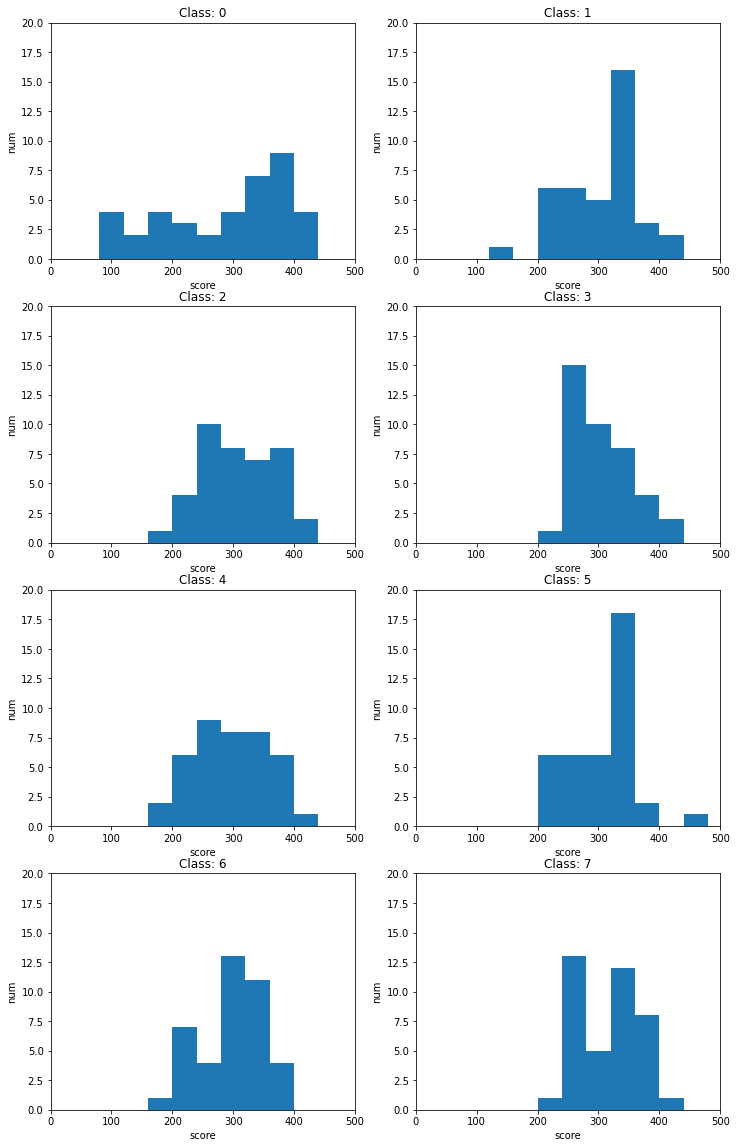

In [33]:
fig = plt.figure(figsize=(12,20))
for c in range(num_of_class):
    df_cls = df_st_r[df_st_r.assigned_class==c]
    ax = fig.add_subplot(4
                        ,2
                        ,c+1
                        ,xlabel='score'
                        ,ylabel='num'
                        ,xlim=(0, 500)
                        ,ylim=(0,20)
                        ,title=f'Class: {c}')
    ax.hist(df_cls.score, bins=range(0,500,40))

In [34]:
# update the results
df_st['score_rank'] = df_st.score.rank(ascending=False, method='first')

df_st['init_assigned_class'] = df_st.score_rank.map(lambda x: x % 8)
df_st

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class
1,1,0,0,0,335,109.0,5.0
2,2,1,0,0,379,38.0,6.0
3,3,0,0,0,350,79.0,7.0
4,4,0,0,0,301,172.0,4.0
5,5,1,0,0,317,147.0,3.0
...,...,...,...,...,...,...,...
314,314,0,0,0,244,263.0,7.0
315,315,1,0,0,309,162.0,2.0
316,316,0,0,0,239,272.0,0.0
317,317,1,0,0,356,63.0,7.0


In [35]:
# create init_flag

init_flag = {(s, c):0 for s in st_list for c in range(num_of_class)}

for row in df_st.itertuples():
    init_flag[row.student_id, row.init_assigned_class] = 1

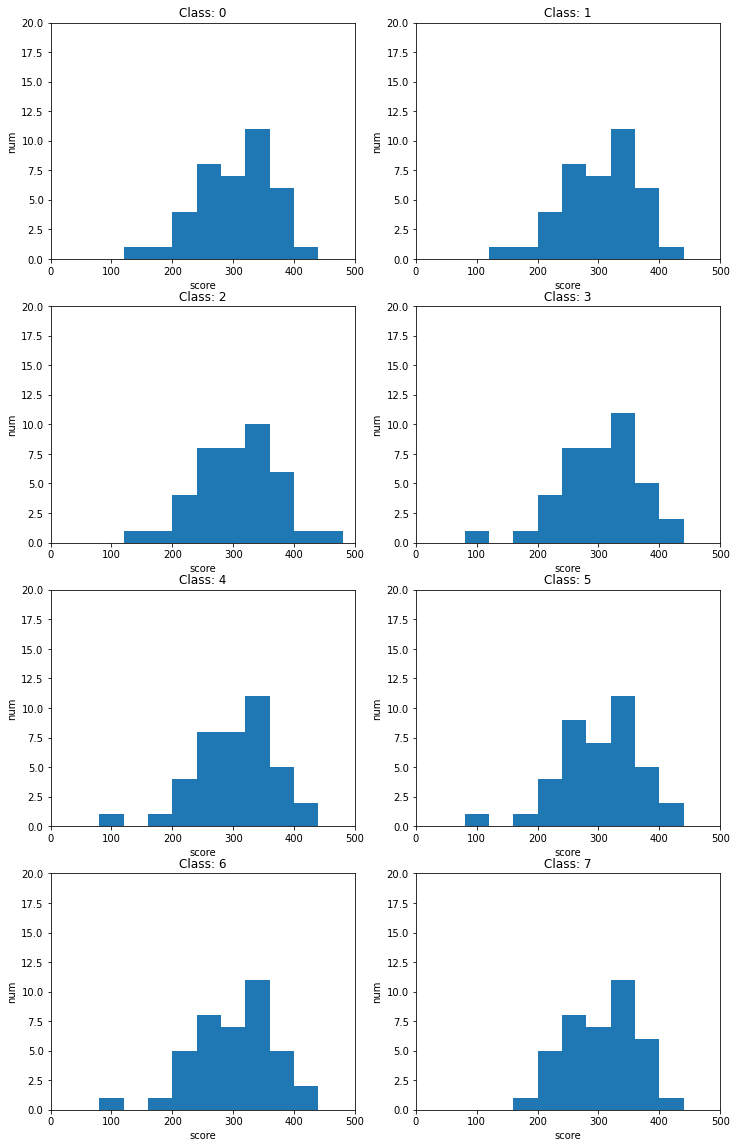

In [36]:
fig = plt.figure(figsize=(12,20))
for c in range(num_of_class):
    df_cls = df_st[df_st.init_assigned_class==c]
    ax = fig.add_subplot(4
                        ,2
                        ,c+1
                        ,xlabel='score'
                        ,ylabel='num'
                        ,xlim=(0, 500)
                        ,ylim=(0,20)
                        ,title=f'Class: {c}')
    ax.hist(df_cls.score, bins=range(0,500,40))

In [37]:
problem = pulp.LpProblem('school-class', pulp.LpMaximize)
x = pd.DataFrame([[pulp.LpVariable(f'x_{i}_{c}',cat='Binary') for c in range(num_of_class)] for i in st_list], index=st_list)

problem += pulp.lpDot(x, init_flag)

for i in x.index:
    problem += pulp.lpSum(x.loc[i,:]) == 1 # condition 1

for j in x.columns:
    problem += pulp.lpSum(x[j]) >= 39 # condition 2
    problem += pulp.lpSum(x[j]) <= 40 # condition 2

    problem += pulp.lpDot(x[j], df_st.gender) <= 20 # condition 3
    problem += pulp.lpDot(x[j], (1 - df_st.gender)) <= 20 # condition 3

    problem += pulp.lpDot(x[j], df_st.score) >= (mean_score - 10)* pulp.lpSum(x[j])# condition 4 -> convert to linier
    problem += pulp.lpDot(x[j], df_st.score) <= (mean_score + 10)* pulp.lpSum(x[j])# condition 4

    problem += pulp.lpDot(x[j], df_st.leader_flag) >= 2 # condition 5

    problem += pulp.lpDot(x[j], df_st.support_flag) <= 1 # condition 6

    for _, r in df_pr.iterrows():
        problem += x.loc[r.student_id1, j] + x.loc[r.student_id2, j] <= 1

status = problem.solve()




In [38]:
pulp.LpStatus[status]

'Optimal'

In [39]:
df_result2 = x.applymap(lambda i: i.value())

In [40]:
assign_dict2 = {i:c for i in st_list for c in range(num_of_class) if df_result2.loc[i,c] == 1}
df_st_r2 = df_st.copy()
df_st_r2['assigned_class'] = df_st_r2.student_id.map(assign_dict2)
df_st_r2

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class,assigned_class
1,1,0,0,0,335,109.0,5.0,7
2,2,1,0,0,379,38.0,6.0,2
3,3,0,0,0,350,79.0,7.0,7
4,4,0,0,0,301,172.0,4.0,2
5,5,1,0,0,317,147.0,3.0,4
...,...,...,...,...,...,...,...,...
314,314,0,0,0,244,263.0,7.0,3
315,315,1,0,0,309,162.0,2.0,2
316,316,0,0,0,239,272.0,0.0,1
317,317,1,0,0,356,63.0,7.0,5


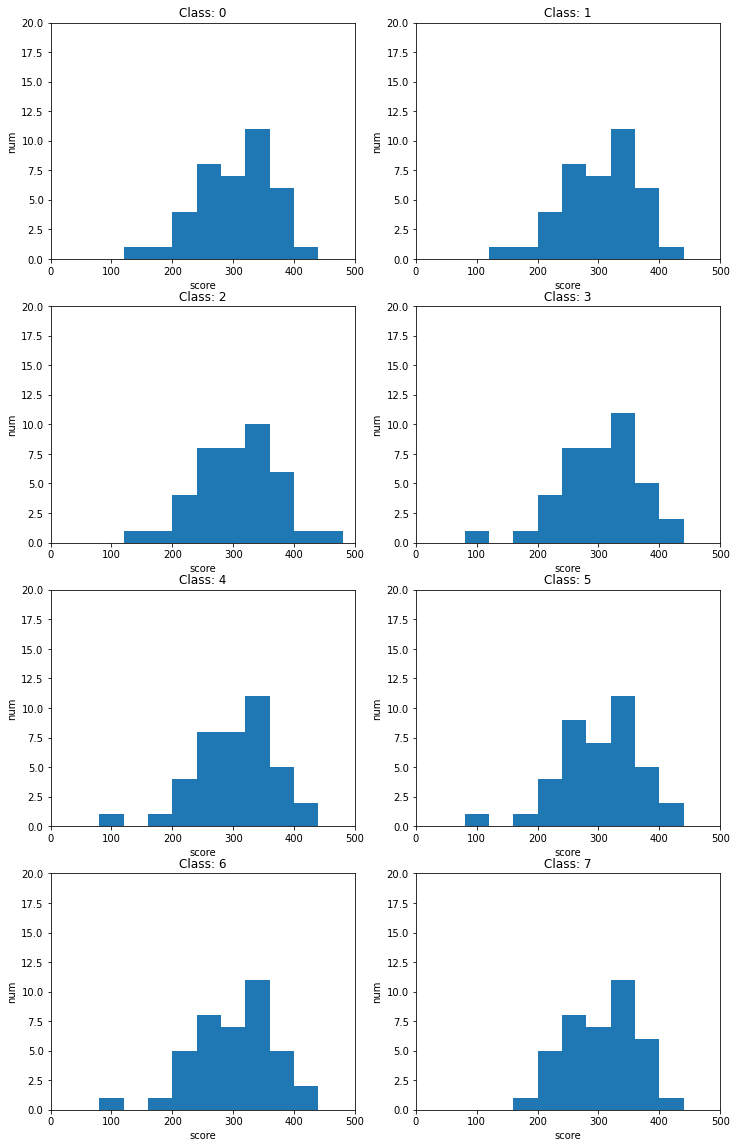

In [41]:
fig = plt.figure(figsize=(12,20))
for c in range(num_of_class):
    df_cls = df_st_r2[df_st_r2.init_assigned_class==c]
    ax = fig.add_subplot(4
                        ,2
                        ,c+1
                        ,xlabel='score'
                        ,ylabel='num'
                        ,xlim=(0, 500)
                        ,ylim=(0,20)
                        ,title=f'Class: {c}')
    ax.hist(df_cls.score, bins=range(0,500,40))